In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2Model, get_linear_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import warnings

In [ ]:
# --- Configuration ---
warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'gpt2' # Using the base GPT-2 model for efficiency
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

print(f"Using device: {DEVICE}")

# --- Part 1: Data Preparation ---
print("\n--- Part 1: Data Preparation ---")

# a) Load the IMDb dataset
raw_datasets = load_dataset("imdb")

Using device: cuda

--- Part 1: Data Preparation ---


In [ ]:
raw_datasets["train"].features["label"]

ClassLabel(names=['neg', 'pos'])

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

# Labels already int-coded; names are:
print(raw_datasets["train"].features["label"].names)  # ['neg','pos']

# Stratified train/val split
splits = raw_datasets["train"].train_test_split(
    test_size=0.2, seed=42, stratify_by_column="label"
)
train_dataset_raw = splits["train"].shuffle(seed=42)
val_dataset_raw   = splits["test"].shuffle(seed=42)   # this is the validation set
test_dataset_raw  = raw_datasets["test"]

# (optional) check distribution
import numpy as np
print("Train dist:", np.unique(train_dataset_raw["label"], return_counts=True))
print("Val dist:",   np.unique(val_dataset_raw["label"],   return_counts=True))
print("Test dist:",  np.unique(test_dataset_raw["label"],  return_counts=True))


['neg', 'pos']
Train dist: (array([0, 1]), array([10000, 10000]))
Val dist: (array([0, 1]), array([2500, 2500]))
Test dist: (array([0, 1]), array([12500, 12500]))


In [ ]:
# --- Part 2: Tokenization with GPT-2 ---
print("\n--- Part 2: Tokenization ---")

# a) Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)

# b) Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set PAD token to EOS token.")

# c) Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt" # Return PyTorch tensors
    )

# --- Part 3: Dataset and DataLoader ---
print("\n--- Part 3: Custom Dataset and DataLoader ---")

# a) Create custom IMDbDataset class
class IMDbDataset(Dataset):
    def __init__(self, dataset_raw, tokenizer, max_len):
        self.dataset = dataset_raw
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item['text']
        label = item['label']

        # Tokenize on the fly
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Instantiate datasets
train_dataset = IMDbDataset(train_dataset_raw, tokenizer, MAX_LEN)
val_dataset = IMDbDataset(val_dataset_raw, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(test_dataset_raw, tokenizer, MAX_LEN)

# b) Wrap using PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully.")


--- Part 2: Tokenization ---
Set PAD token to EOS token.

--- Part 3: Custom Dataset and DataLoader ---
DataLoaders created successfully.


In [ ]:
# --- Part 4: Model Definition ---
print("\n--- Part 4: Model Definition ---")
class GPT2SentimentClassifier(nn.Module):
    def __init__(self, model_name, freeze_gpt=True):
        super(GPT2SentimentClassifier, self).__init__()
        # a) Use GPT-2 model as backbone
        self.gpt2 = GPT2Model.from_pretrained(model_name)

        # We must resize token embeddings because we added a new token
        self.gpt2.resize_token_embeddings(len(tokenizer))

        # Freeze GPT-2 parameters if specified
        if freeze_gpt:
            for param in self.gpt2.parameters():
                param.requires_grad = False

        # b) Add a classification head
        config = self.gpt2.config
        self.classifier = nn.Linear(config.hidden_size, 2) # Binary classification

    def forward(self, input_ids, attention_mask):
        gpt_outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # For classification with autoregressive models like GPT-2,
        # using the hidden state of the last token is a common and effective strategy.
        last_hidden_state = gpt_outputs.last_hidden_state # [batch, seq_len, hidden_dim]

        # Find the index of the last non-padded token for each sequence
        # The attention mask is 1 for non-padded tokens and 0 for padded ones.
        # We can get the length of each sequence by summing the attention mask.
        seq_lengths = attention_mask.sum(dim=1) - 1 # Get index of last token

        # Use advanced indexing to pull out the hidden state of the last non-pad token
        # This is more robust than simply taking last_hidden_state[:, -1, :]
        batch_indices = torch.arange(last_hidden_state.size(0)).to(last_hidden_state.device)
        pooled_output = last_hidden_state[batch_indices, seq_lengths, :]

        logits = self.classifier(pooled_output)
        return logits

model = GPT2SentimentClassifier(MODEL_NAME, freeze_gpt=True).to(DEVICE)
print("Model architecture defined and instantiated.")
# Optional: Print number of trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}, Trainable params: {trainable_params:,}")



--- Part 4: Model Definition ---
Model architecture defined and instantiated.
Total params: 124,441,346, Trainable params: 1,538



--- Part 5: Training and Validation ---

--- Epoch 1/4 ---


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.9117 | Train Acc: 51.41%
Val.  Loss: 0.6987 | Val.  Acc: 57.96%

--- Epoch 2/4 ---


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.7356 | Train Acc: 58.43%
Val.  Loss: 0.6295 | Val.  Acc: 66.20%

--- Epoch 3/4 ---


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6697 | Train Acc: 63.52%
Val.  Loss: 0.6066 | Val.  Acc: 69.28%

--- Epoch 4/4 ---


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6385 | Train Acc: 66.31%
Val.  Loss: 0.6008 | Val.  Acc: 70.04%


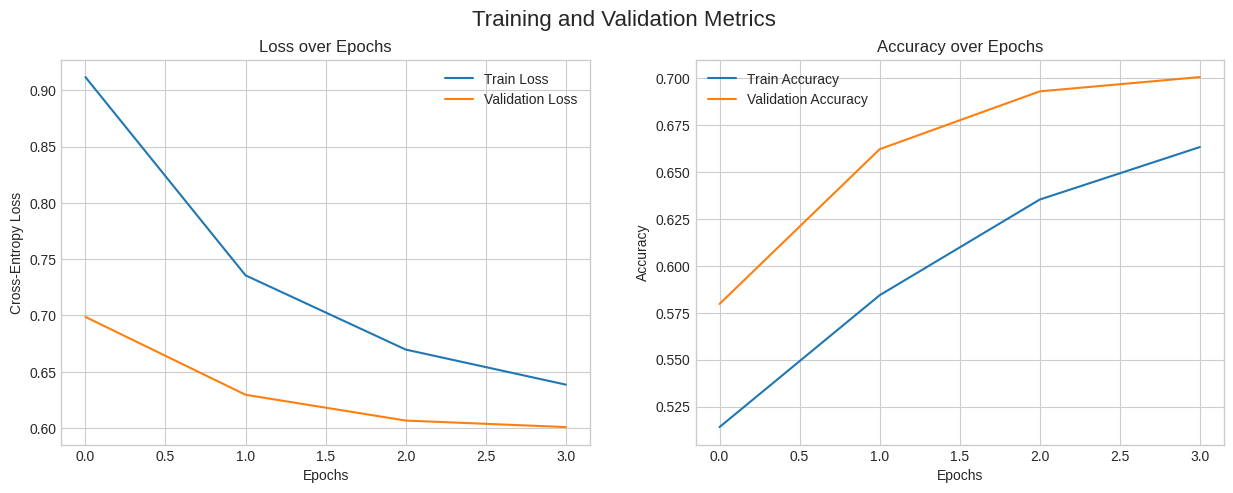

In [ ]:
# --- Part 5: Training and Validation ---
print("\n--- Part 5: Training and Validation ---")

# a) Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

# Scheduler for learning rate
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss, total_correct = 0, 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset)
    return avg_loss, avg_acc

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            total_correct += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset)
    return avg_loss, avg_acc

# b) Training Loop
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, DEVICE, scheduler)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, DEVICE)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val.  Loss: {val_loss:.4f} | Val.  Acc: {val_acc*100:.2f}%')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

# c) Plotting metrics
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Metrics', fontsize=16)

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.savefig("training_metrics.png")
plt.show()



--- Part 6: Final Evaluation on Test Set ---


Testing:   0%|          | 0/1563 [00:00<?, ?it/s]

Final Test Accuracy: 70.30%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.63      0.68     12500
    Positive       0.68      0.77      0.72     12500

    accuracy                           0.70     25000
   macro avg       0.71      0.70      0.70     25000
weighted avg       0.71      0.70      0.70     25000



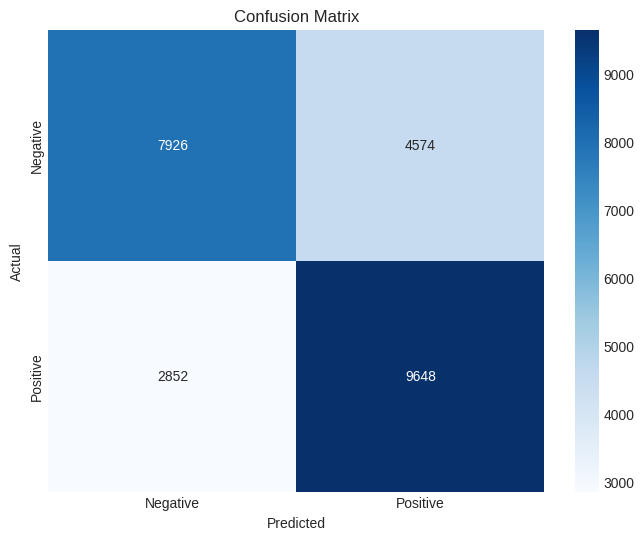

In [ ]:
# --- Part 6: Evaluation ---
print("\n--- Part 6: Final Evaluation on Test Set ---")

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    return predictions, real_values

y_pred, y_test = get_predictions(model, test_loader, DEVICE)

# a) Final Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")

# b) Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("confusion_matrix.png")
plt.show()


In [ ]:
# --- Part 7: Prediction Function ---
print("\n--- Part 7: Inference on New Examples ---")

def predict(text: str, model, tokenizer, device, max_len=256):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    probs = torch.softmax(outputs, dim=1)
    confidence, pred_label_idx = torch.max(probs, dim=1)

    label = "Positive" if pred_label_idx.item() == 1 else "Negative"

    return label, confidence.item()


--- Part 7: Inference on New Examples ---


In [ ]:

# Example reviews
example_reviews = [
    "This movie was an absolute masterpiece! The acting was superb, and the plot was gripping from start to finish.",
    "A complete waste of time. The plot was nonsensical and the characters were one-dimensional.",
    "It was an okay movie. Not great, not terrible. Just... meh.",
    "I was on the edge of my seat! A cinematic experience I won't forget anytime soon. Highly recommended!"
]

for review in example_reviews:
    label, confidence = predict(review, model, tokenizer, DEVICE, MAX_LEN)
    print(f"Review: \"{review[:50]}...\"")
    print(f"  -> Prediction: {label} (Confidence: {confidence:.4f})\n")

Review: "This movie was an absolute masterpiece! The acting..."
  -> Prediction: Positive (Confidence: 0.6538)

Review: "A complete waste of time. The plot was nonsensical..."
  -> Prediction: Negative (Confidence: 0.5796)

Review: "It was an okay movie. Not great, not terrible. Jus..."
  -> Prediction: Negative (Confidence: 0.5653)

Review: "I was on the edge of my seat! A cinematic experien..."
  -> Prediction: Positive (Confidence: 0.8234)

